In [1]:
import os
import sys
sys.path.append('../')

import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

import utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
load_dotenv()

connection_string = "postgresql://{user}:{password}@{host}:{port}/{db}".format(
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    db=os.getenv('DB_NAME')
)
engine = create_engine(connection_string)

In [5]:
BIN_SIZE = 5
query = f"""
WITH
launches AS (
    SELECT
        *,
        glideator.get_gfs_coords(latitude::numeric, longitude::numeric) AS gfs_coords
    FROM glideator_mart.dim_launches
),
stats AS (
    SELECT
        launch,
        date,
        flight_registered
    FROM glideator_mart.mart_daily_flight_stats
),
wind_binned AS (
    SELECT
        launches.name AS launch,
        date,
        glideator.bin_wind_direction(
            glideator.get_wind_direction(u_wind_10m_ms::numeric, v_wind_10m_ms::numeric),
            {BIN_SIZE}
        ) AS wind_bin
    FROM launches 
    LEFT JOIN source.gfs gfs
    ON gfs.lat = launches.gfs_coords[1]
    AND gfs.lon = launches.gfs_coords[2]
),
wind_with_stats AS (
    SELECT
        stats.launch,
        wind_binned.wind_bin,
        {BIN_SIZE} AS bin_width,
        AVG(flight_registered) * 100 AS flight_percentage,
        COUNT(stats.date) AS num_days
    FROM wind_binned
    LEFT JOIN stats
    ON wind_binned.launch = stats.launch
    AND wind_binned.date = stats.date
    GROUP BY stats.launch, wind_binned.wind_bin
),
wind_with_launch AS (
    SELECT
        launch,
        wind_bin,
        bin_width,
        flight_percentage,
        num_days,
        usable_wind_range1,
        usable_wind_range2
    FROM wind_with_stats
    LEFT JOIN launches
    ON wind_with_stats.launch = launches.name
)
SELECT * FROM wind_with_launch
"""
df = pd.read_sql(query, engine)

In [6]:
df.head()

,launch,wind_bin,bin_width,flight_percentage,num_days,usable_wind_range1,usable_wind_range2
0,Brná,2.5,5,0.0,23,"[180, 210]",None
1,Brná,7.5,5,0.0,19,"[180, 210]",None
2,Brná,12.5,5,0.0,14,"[180, 210]",None
3,Brná,17.5,5,0.0,11,"[180, 210]",None
4,Brná,22.5,5,0.0,9,"[180, 210]",None


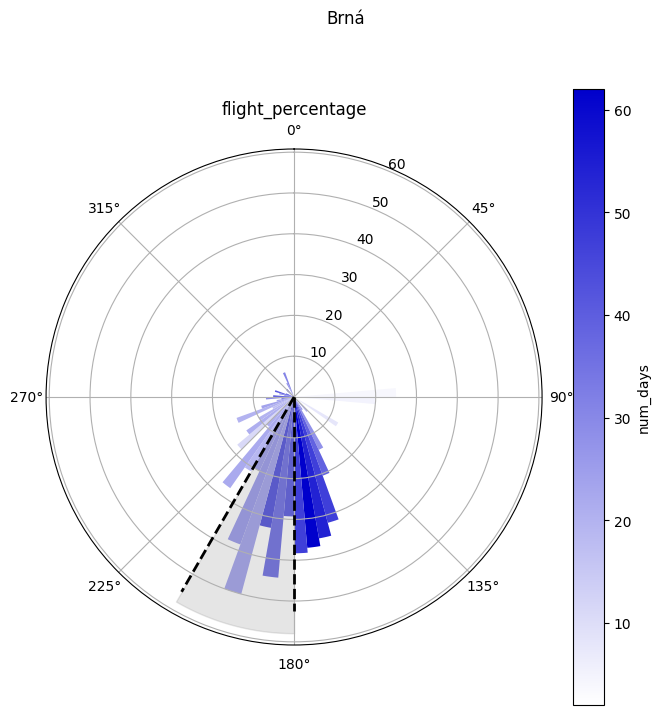

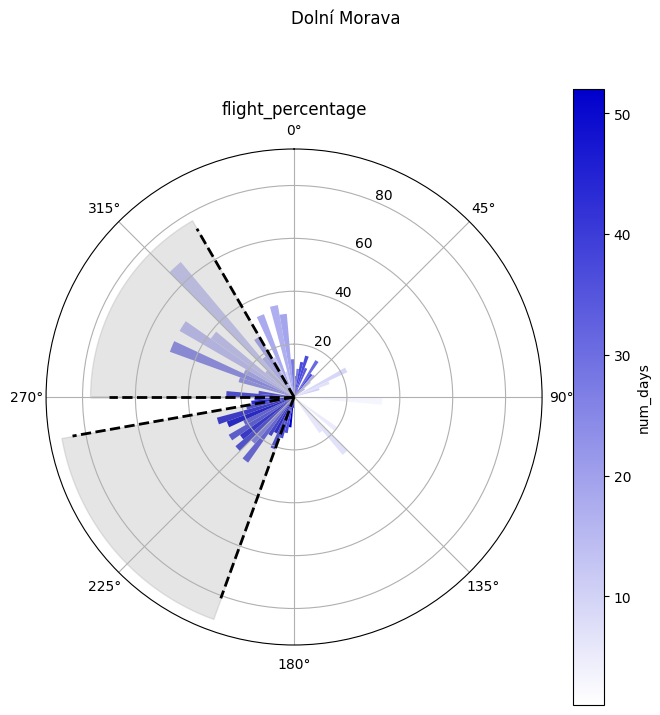

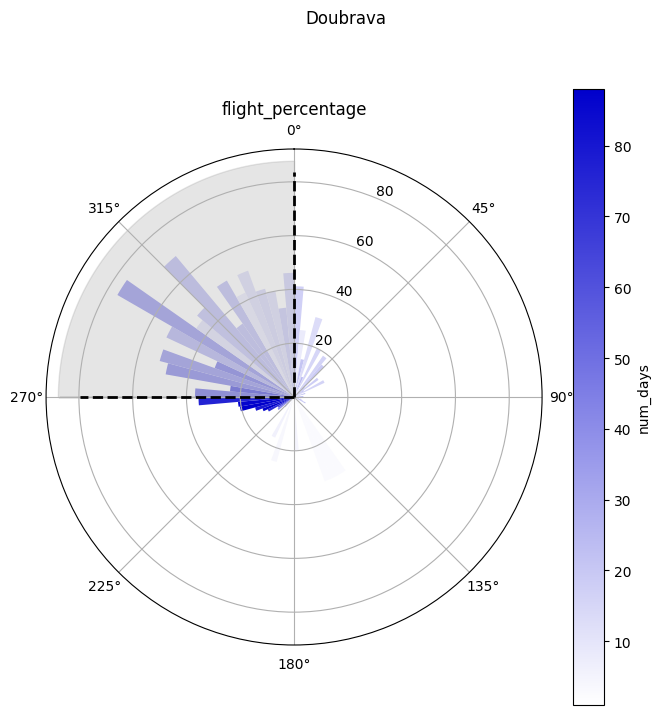

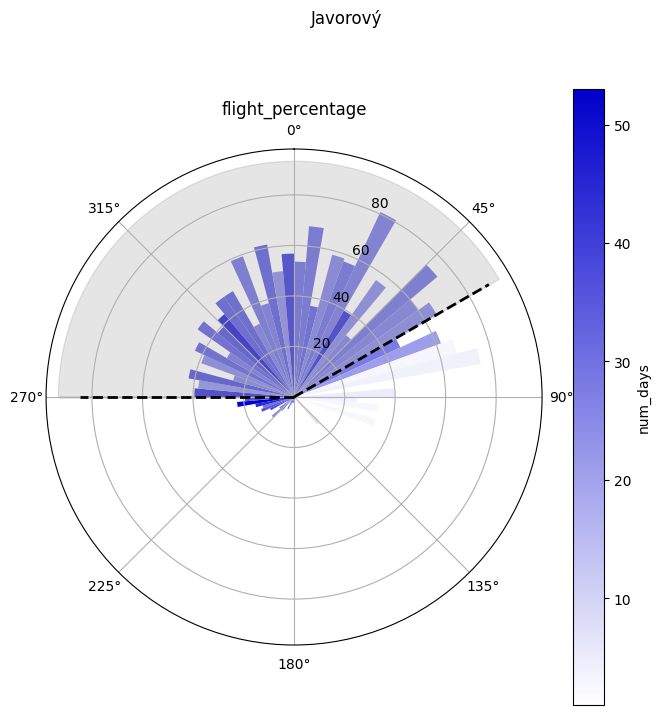

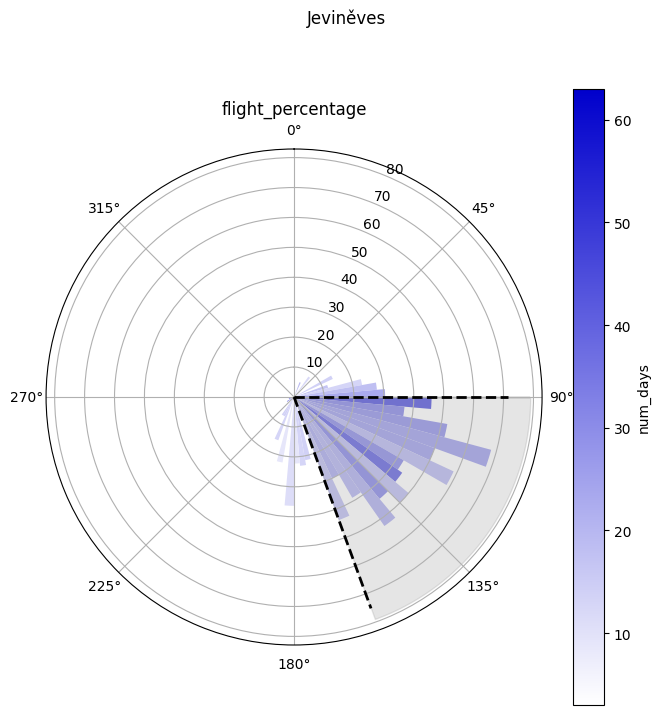

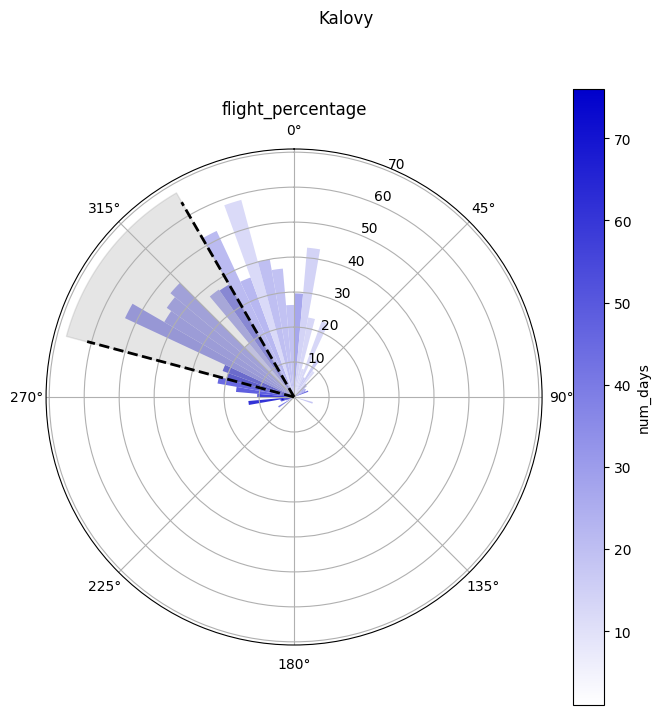

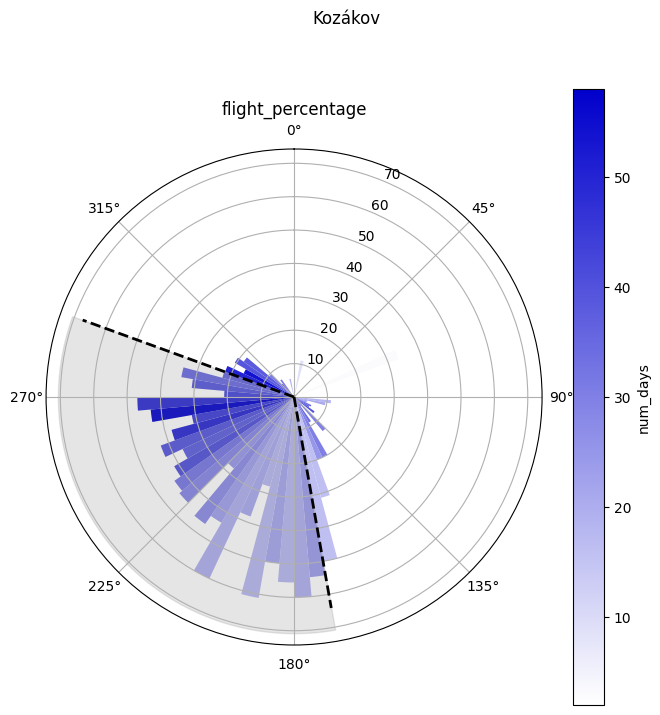

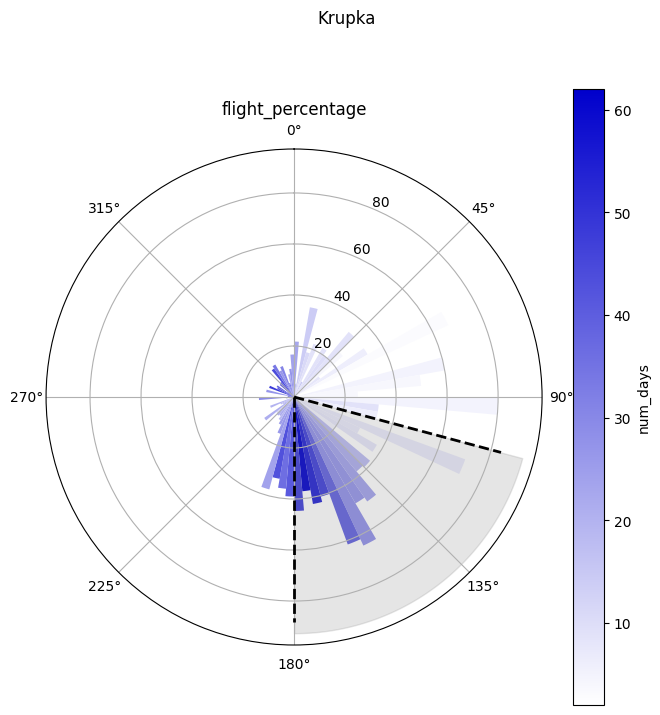

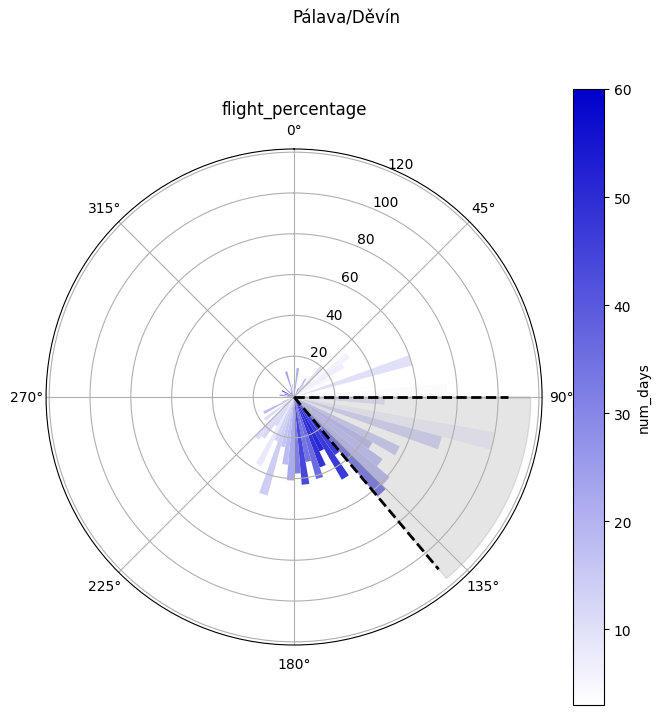

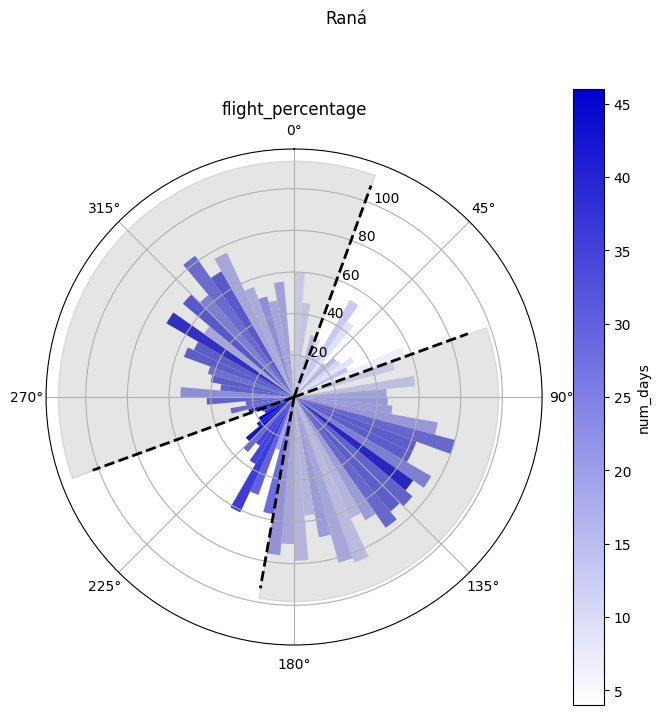

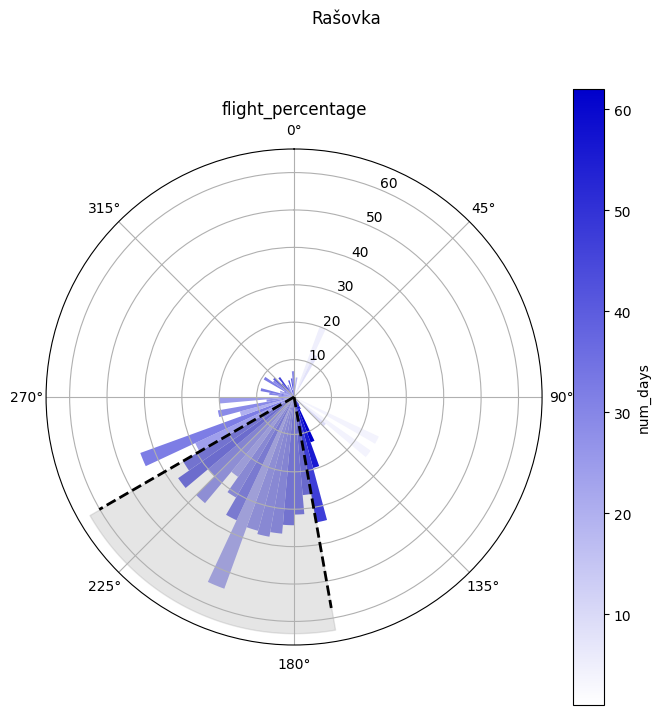

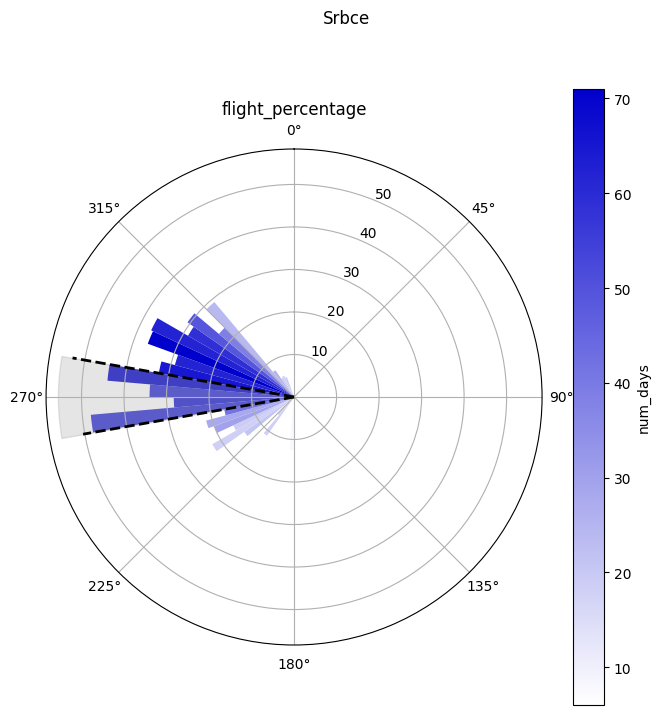

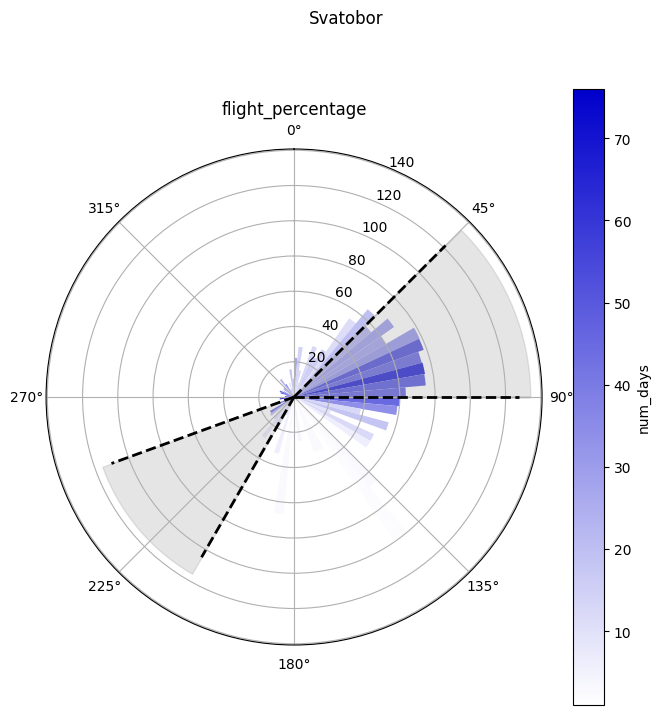

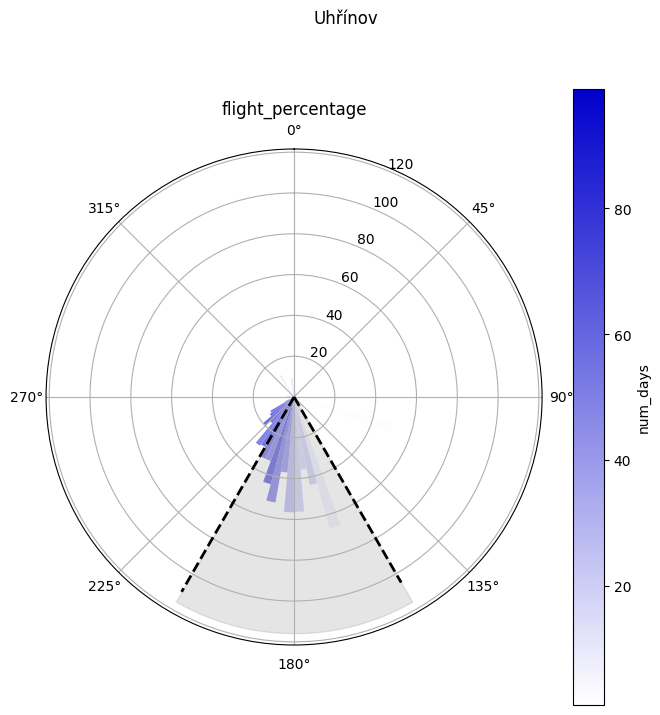

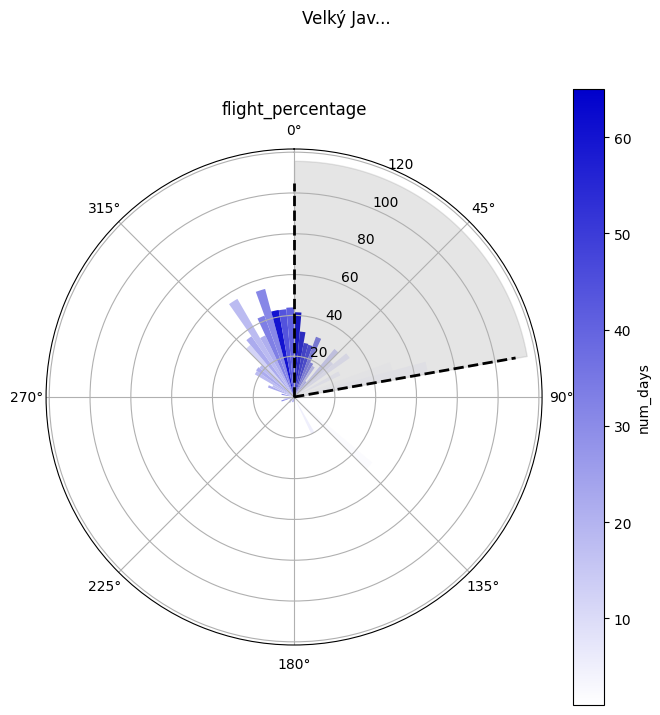

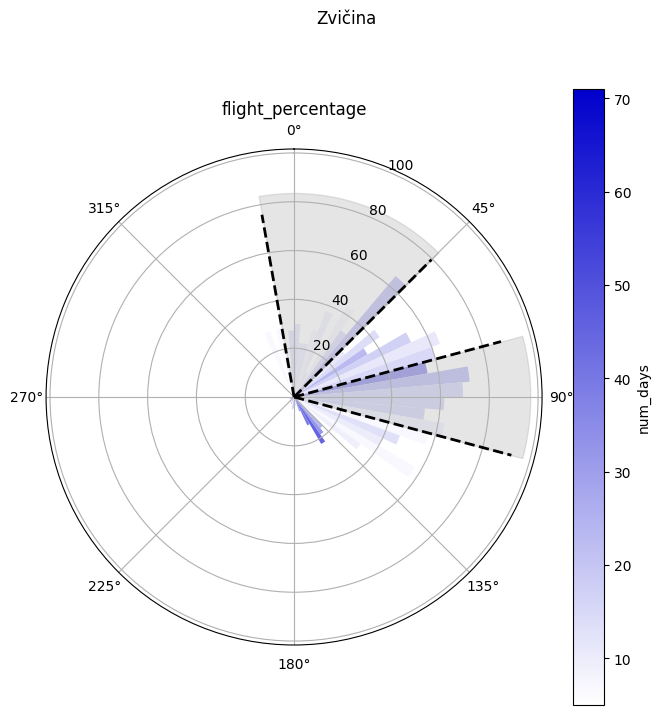

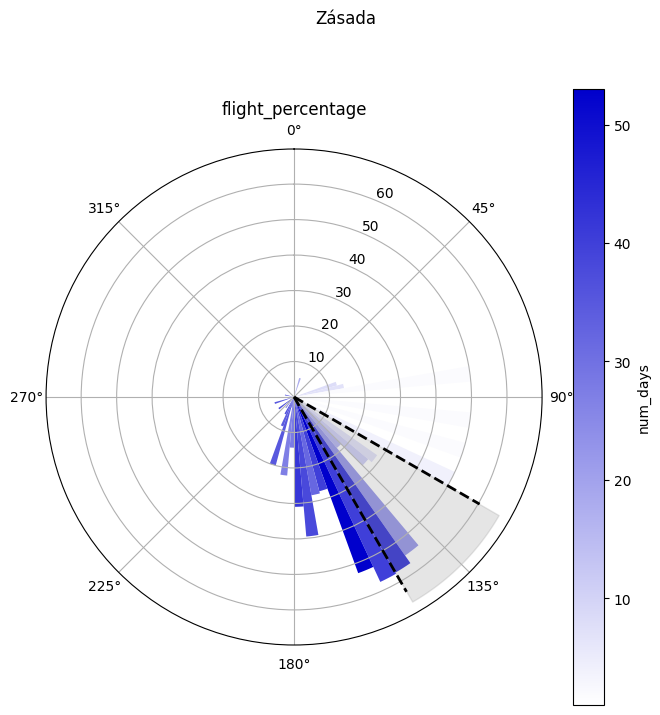

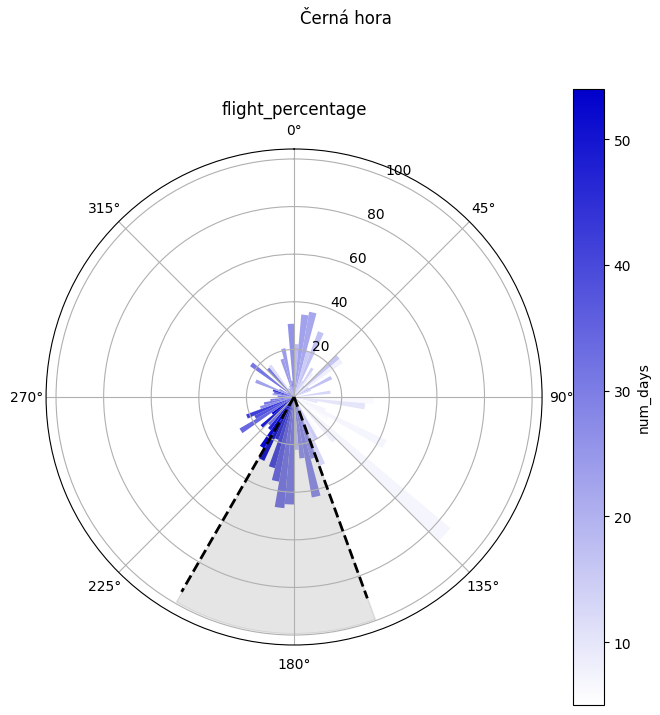

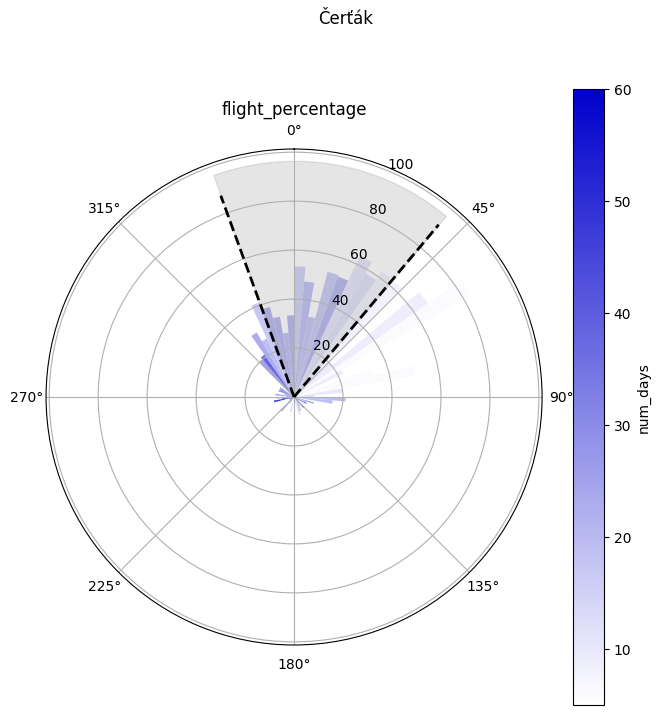

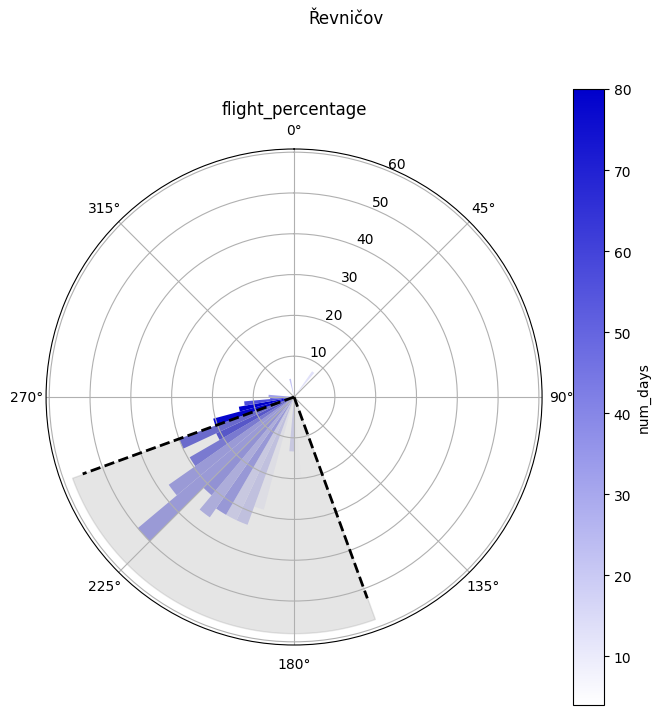

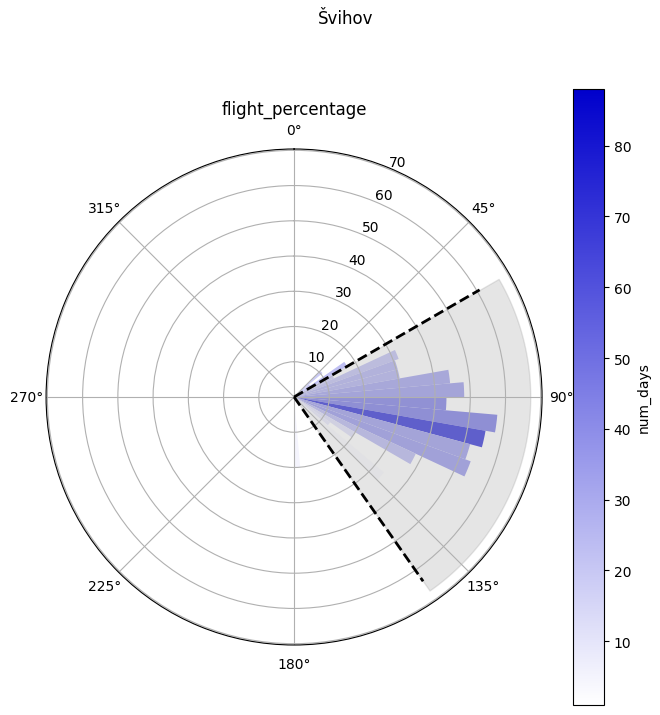

In [7]:
for launch in sorted(df['launch'].unique()):
    launch_df = df.query(f'launch == {launch!r}')
    label = launch_df['launch'].iloc[0]
    range1 = launch_df['usable_wind_range1'].iloc[0]
    range2 = launch_df['usable_wind_range2'].iloc[0]
    bin_size = launch_df['bin_width'].iloc[0]
    utils.polar_plot(launch_df, bar_col='flight_percentage', color_col='num_days', label=label, bin_size=bin_size, range1=range1, range2=range2, max_value=None)